In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy

import jax
import jax.numpy as jnp
import jaxopt

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.efm as exp_efm

# Load EFM results

In [23]:
data_res = pickle.load(open("../data/efm/efm_hmc_n3000_seed0.pkl", "rb"))

In [25]:
states = np.stack([xx[0] for xx in data_res["state"]], 0)

In [26]:
states.shape

(3000, 5)

In [81]:
true_params = np.array([-1., 0])

efm = exp_efm.EFM(true_params)

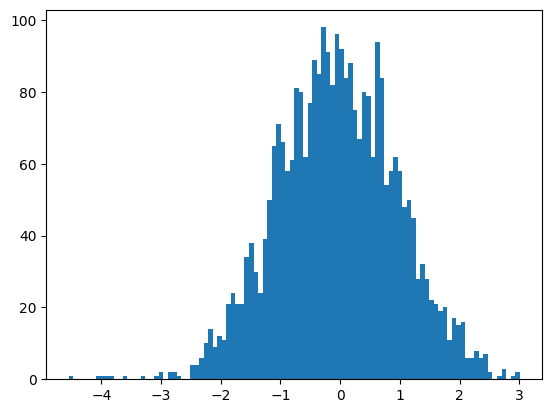

In [40]:
_ = plt.hist(states[:, 4], bins=100)

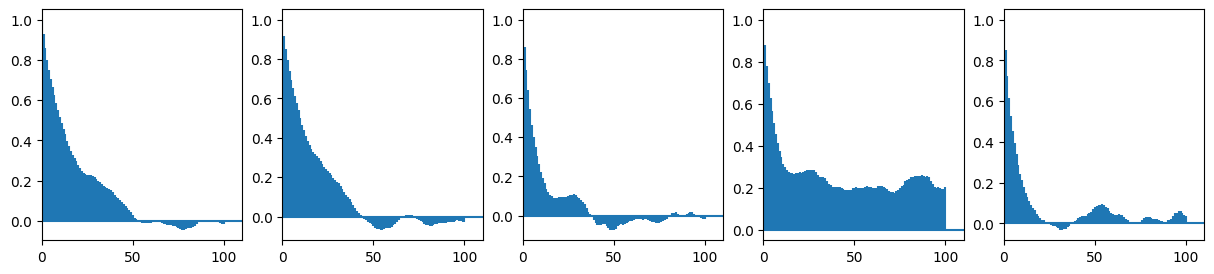

In [53]:
_, axes = plt.subplots(ncols=5, figsize=(15, 3))
for i, ax in enumerate(axes.flatten()):
    ax.acorr(states[:, i], maxlags = 100)
    ax.set_xlim(0.)

In [86]:
X = states[::50]
efm.sm_est(X)

Array([-1.0587883 ,  0.03012102], dtype=float32)

In [217]:
np.random.seed(2024)

efm = exp_efm.EFM(np.zeros((2,)))
X = efm.sample(1000)
kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
efm.ksd_est(X, kernel)

/home/clustor/ma/x/xl6116/research/robust-kernel-test/experiments/efm.py:69: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return x


Array([ 0.02641327, -0.00542635], dtype=float32)

In [218]:
np.random.seed(2024)
X_contam = efm.sample_contam(1000, eps=0.05, outlier=10. * np.ones((5,)))
kernel = kernels.IMQ(med_heuristic=True, X=X_contam, Y=X_contam)
efm.ksd_est(X_contam, kernel)

Array([0.30054438, 0.29845858], dtype=float32)

In [220]:
np.random.seed(2024)
X = efm.sample(5000)
kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
efm.ksd_est(X, kernel)

In [ ]:
efm.sm_est(X)

In [238]:
np.random.seed(2024)
X = efm.sample(200)
kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
est_params = efm.ksd_est(X, kernel)

/home/clustor/ma/x/xl6116/research/robust-kernel-test/experiments/efm.py:69: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return x


In [244]:
# est_efm = exp_efm.EFM(est_params)
est_efm = exp_efm.EFM(np.zeros((2,)))

score, hvp = est_efm.compute_grad_and_hvp(X)

In [223]:
hvp_denom_sup = 1.
X_res = np.expand_dims(X, 0)
score_res = np.expand_dims(score, 0)
hvp_res = np.expand_dims(hvp, 0)

theta = 0.1

In [224]:
res = exp_utils.run_tests(
    samples=X_res, scores=score_res, hvps=hvp_res, hvp_denom_sup=hvp_denom_sup, 
    theta=theta, bw="med", alpha=0.05, verbose=True,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


In [225]:
res["rbf"]

{'nonsq_stat': [Array(0.16259159, dtype=float32)],
 'stat': [Array(0.02643602, dtype=float32)],
 'u_stat': [],
 'pval': [Array(0.65634364, dtype=float32, weak_type=True)],
 'rej': [0],
 'boot_stats': [array([0.02309129, 0.03696243, 0.03051676, 0.03181617, 0.03263012,
         0.02389938, 0.02468866, 0.03978031, 0.03009584, 0.01947895,
         0.02849437, 0.03016425, 0.02288527, 0.02470086, 0.02317857,
         0.01772941, 0.05685254, 0.01679318, 0.02728976, 0.03630476,
         0.03422087, 0.03137206, 0.02511796, 0.035787  , 0.03514912,
         0.02400936, 0.02538567, 0.03270467, 0.0310781 , 0.02944112,
         0.04030979, 0.02804152, 0.02266177, 0.03005852, 0.0311309 ,
         0.03366491, 0.01948159, 0.02829609, 0.03033528, 0.04010079,
         0.02195832, 0.02945221, 0.02692001, 0.02807494, 0.03733991,
         0.02431225, 0.0223873 , 0.03349234, 0.02172165, 0.02788307,
         0.03335116, 0.02952903, 0.02459374, 0.03505342, 0.02941951,
         0.04105745, 0.03623332, 0.0365737

In [235]:
np.allclose(score_res, jax.vmap(jax.grad(est_efm.log_unnormalised_density))(X))

True

# Load test results

In [274]:
res_stats = pickle.load(open("../data/efm/efm_stats_n500.pkl", "rb"))
eps_ls = list(stats_res.keys())

In [275]:
eps_ls

[0.0, 0.01, 0.05, 0.1, 0.2]

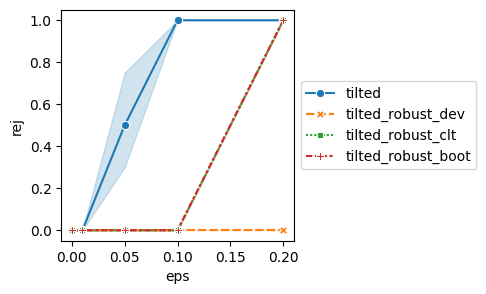

In [281]:
_, ax = plt.subplots(figsize=(3, 3))

res_plot = res_stats
method_list = ["tilted", "tilted_robust_dev", "tilted_robust_clt", "tilted_robust_boot"]

plot_df = {"eps": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    rr = res_plot[eps]["tilted"]["nonsq_stat"]
    for m in method_list:
        plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
        plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
        plot_df["eps"] = plot_df["eps"] + [eps] * len(rr)
        
        plot_df["rej"] = plot_df["rej"] + res_plot[eps][m]["rej"]
        plot_df["method"] = plot_df["method"] + [m] * len(rr)

plot_df = pd.DataFrame(plot_df)

_ = sns.lineplot(ax=ax, data=plot_df, x="eps", y="rej", hue="method", style="method", markers=True)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

theta_new 0.01


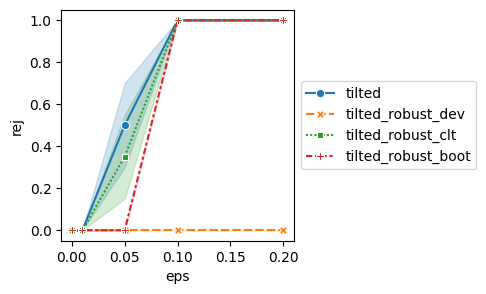

In [282]:
theta_new = 0.01
print("theta_new", theta_new)
# change theta
res_new = copy.deepcopy(res_stats)
for eps in eps_ls:
    res_new[eps] = exp_utils.change_theta(
        res_new[eps], ["tilted_robust_dev", "tilted_robust_clt", "tilted_robust_boot"], theta_new)


_, ax = plt.subplots(figsize=(3, 3))

res_plot = res_new
method_list = ["tilted", "tilted_robust_dev", "tilted_robust_clt", "tilted_robust_boot"]

plot_df = {"eps": [], "nonsq_stat": [], "nonsq_u_stat": [], "method": [], "rej": []}
for eps in eps_ls:
    rr = res_plot[eps]["tilted"]["nonsq_stat"]
    for m in method_list:
        plot_df["nonsq_stat"] = plot_df["nonsq_stat"] + np.array(rr).tolist()
        plot_df["nonsq_u_stat"] = plot_df["nonsq_u_stat"] + (np.array(rr)**0.5).tolist()
        plot_df["eps"] = plot_df["eps"] + [eps] * len(rr)
        
        plot_df["rej"] = plot_df["rej"] + res_plot[eps][m]["rej"]
        plot_df["method"] = plot_df["method"] + [m] * len(rr)

plot_df = pd.DataFrame(plot_df)

_ = sns.lineplot(ax=ax, data=plot_df, x="eps", y="rej", hue="method", style="method", markers=True)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# RBM

In [59]:
from kgof import data as kgof_data
# from kgof import density as kgof_den
import src.kgof_density as kgof_den

In [19]:
seed = 2024
key = jax.random.key(seed)
keys = jax.random.split(key, 3)

dim = 50
h_dim = 10
b = jax.random.normal(keys[0], shape=(dim,))
c = jax.random.normal(keys[1], shape=(h_dim,))
B = jax.random.bernoulli(keys[2], shape=(dim, h_dim)).astype(jnp.float32) * 2 - 1.

In [21]:
rbm_sampler = kgof_data.DSGaussBernRBM(B, b, c)

In [125]:
rbm_samples = rbm_sampler.sample(500).data()

/home/ma/x/xl6116/.envs/robust/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


In [126]:
rbm_model = kgof_den.GaussBernRBM(B, b, c)

In [127]:
X = rbm_samples
score = rbm_model.grad_log(X)

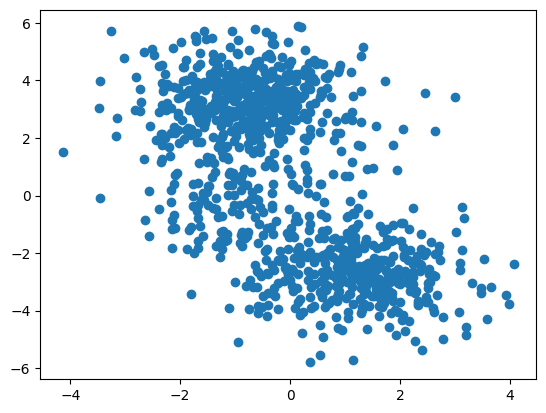

In [128]:
plt.scatter(X[:, 0], X[:, 1])

In [129]:
score_weight_fn = kernels.PolyWeightFunction(loc=jnp.zeros_like(X[0]))
kernel0 = kernels.RBF(med_heuristic=True, X=X, Y=X)
kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
ksd = metrics.KSD(kernel, score_fn=rbm_model.grad_log)

In [131]:
def obj(x):
    s = ksd.score_fn(x)
    return -ksd(x, x, score=s, vstat=True)

def weighted_score(x):
    s = ksd.score_fn(x)
    w = score_weight_fn(x)
    return -jnp.sum((w * s)**2)

In [132]:
init_val = X[[0], :]
solver = jaxopt.LBFGS(fun=obj, maxiter=500)
opt_res = solver.run(init_val)

In [133]:
print(opt_res.params)
print(opt_res.state)

[[ 0.01224244  0.04712794 -0.0744492   0.01910656 -0.07204443  0.0522138
   0.00119117  0.01979957 -0.00893776 -0.04123699 -0.00758436  0.03677427
  -0.03929169 -0.03743457  0.07158471 -0.02437767 -0.03335309 -0.04584221
   0.02217007 -0.03428461 -0.08729164 -0.01204521  0.0032291  -0.05533231
   0.0643128   0.03245837  0.03583763 -0.0570328  -0.07639275 -0.03352051
  -0.01354919 -0.00512839 -0.01839444  0.00423843 -0.05260507  0.06874473
   0.07227337  0.00015255  0.05585834  0.01527251 -0.06223199  0.00411649
  -0.02053558  0.08522118 -0.01791378  0.05893361  0.02328771  0.00327299
  -0.01562118 -0.07464185]]
LbfgsState(iter_num=Array(135, dtype=int32, weak_type=True), value=Array(-112.36937, dtype=float32), grad=Array([[-5.84125519e-05, -7.82012939e-05,  5.72204590e-06,
        -6.32852316e-05,  6.19888306e-06, -6.86645508e-05,
         2.19345093e-05, -1.17123127e-04, -3.62396240e-05,
         1.06573105e-04,  1.03950500e-04, -2.32607126e-05,
        -1.13487244e-04,  1.61647797e-0

In [134]:
X_star = opt_res.params
score_star = ksd.score_fn(X_star)
ksd.eval_single_arg(X_star, score_star)

Array([112.36936], dtype=float32)

In [135]:
rr = ksd.eval_single_arg(X, score)
np.max(rr)

Array(0.30622065, dtype=float32)

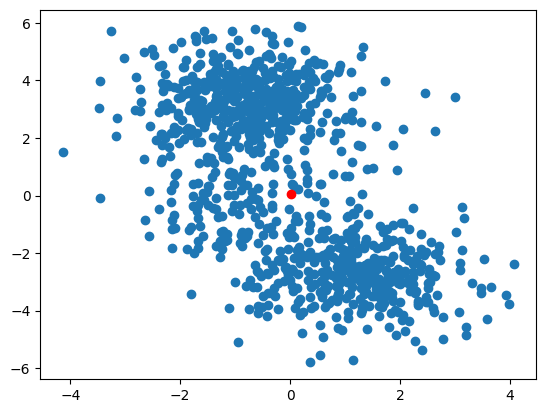

In [136]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X_star[:, 0], X_star[:, 1], color="red")

In [178]:
# X_plot = jnp.repeat(X[[0], :], 100, 0)
X_plot = jnp.zeros_like(X)
idx = [[i] + [0] * (dim-1) for i in range(100)]
# for i, xx in zip(range(X_plot.shape[0]), jnp.arange(-5., 5., X_plot.shape[0])):
#     X_plot = X_plot.at[(i, 0)].set(xx)
X_plot = np.array(X_plot)
X_plot[:, 0] = np.linspace(-5., 5., X_plot.shape[0])
X_plot = jnp.array(X_plot)

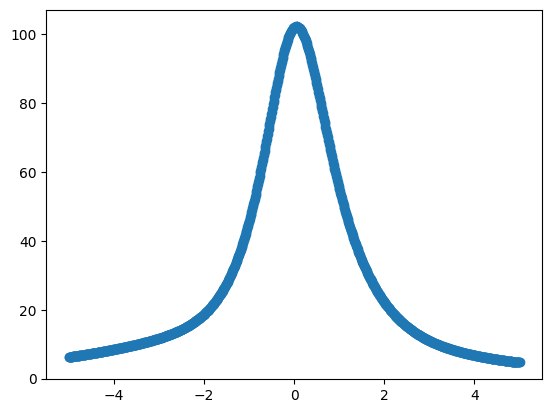

In [179]:
rr_plot = ksd.eval_single_arg(X_plot, ksd.score_fn(X_plot))

plt.scatter(X_plot[:, 0], rr_plot)

In [228]:
rbm_samples = rbm_sampler.sample(500).data()

X = rbm_samples
score = rbm_model.grad_log(X)

np.random.seed(2024)
eps = 0.4
X = exp_efm.sample_outlier_contam(X, eps=eps, ol_mean=np.ones((dim,)), ol_std=0.1)
score = rbm_model.grad_log(X)

Xs = X[jnp.newaxis]
scores = score[jnp.newaxis]

In [229]:
tau = -opt_res.state.value
eps0 = 0.1
theta = eps0 * tau**0.5

In [230]:
weight_fn_args = {"loc": jnp.zeros_like(X[0])}

res = exp_utils.run_tests(
    samples=Xs, scores=scores, hvps=None, 
    hvp_denom_sup=None, weight_fn_args=weight_fn_args,
    theta=theta, bw="med", alpha=0.05, verbose=True,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/it]


In [231]:
res["tilted"]

{'nonsq_stat': [Array(0.5699897, dtype=float32)],
 'stat': [Array(0.32488826, dtype=float32)],
 'u_stat': [Array(0.32343215, dtype=float32)],
 'pval': [Array(0.00199601, dtype=float32)],
 'rej': [1],
 'boot_stats': []}

In [232]:
res["tilted_r_boot"]

{'nonsq_stat': [Array(0.5699897, dtype=float32)],
 'stat': [Array(0.32488826, dtype=float32)],
 'u_stat': [Array(0.32343215, dtype=float32)],
 'threshold': [Array(0.06817125, dtype=float32)],
 'rej': [0],
 'theta': [Array(1.0600442, dtype=float32)],
 'gamma': [Array(0.06817125, dtype=float32)],
 'pval': [Array(1., dtype=float32)]}

In [197]:
theta

Array(1.0600442, dtype=float32)